In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.utils import to_categorical
import keras_tuner as kt
import tensorflow_probability as tfp
import tensorflow as tf
from sklearn.utils import class_weight
import warnings

warnings.filterwarnings("ignore")

n_players_df = pd.read_csv("data/n_players_classifier.csv")

2024-08-10 16:34:33.013860: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-08-10 16:34:33.023994: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-10 16:34:33.035092: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-10 16:34:33.038505: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-10 16:34:33.047008: I tensorflow/core/platform/cpu_feature_guar

In [2]:
columns = list(n_players_df.columns)
columns = columns[columns.index("HomeTeamPlayer1_AST"):columns.index("WL_A")]
len(columns)

204

In [3]:
# Drop rows where the target variable contains NaN
df = n_players_df.dropna(subset=["WL_A"])

# Define features and target
X = df[columns]
y = df["WL_A"]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Standardize the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# One-hot encode the target variable
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

# Apply SMOTE to balance the classes
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

In [4]:
# Custom loss function for Mixture Density Network
def mdn_loss(num_components):
    def loss(y_true, y_pred):
        y_true = tf.expand_dims(y_true, axis=-1)
        gm = tfp.distributions.MixtureSameFamily(
            mixture_distribution=tfp.distributions.Categorical(
                logits=y_pred[:, :num_components]
            ),
            components_distribution=tfp.distributions.Normal(
                loc=y_pred[:, num_components : num_components * 2],
                scale=tf.nn.softplus(y_pred[:, num_components * 2 :]),
            ),
        )
        return -gm.log_prob(y_true)

    return loss


# Define the hypermodel with Mixture Density Network
def build_model(hp):
    model = Sequential()
    model.add(
        Dense(
            units=hp.Int("units", min_value=16, max_value=128, step=16),
            activation=hp.Choice("activation", values=["relu", "tanh"]),
            input_shape=(X_train.shape[1],),
        )
    )
    model.add(Dropout(hp.Float("dropout", min_value=0.0, max_value=0.5, step=0.1)))
    model.add(
        Dense(
            units=hp.Int("units", min_value=16, max_value=128, step=16),
            activation=hp.Choice("activation", values=["relu", "tanh"]),
        )
    )
    model.add(Dropout(hp.Float("dropout", min_value=0.0, max_value=0.5, step=0.1)))

    # Define the parameters for the mixture density network
    num_components = hp.Int("num_components", min_value=2, max_value=10, step=1)
    model.add(
        tf.keras.layers.Dense(num_components * 3)
    )  # 3 parameters per component: mean, stddev, and weight

    model.compile(optimizer="adam", loss=mdn_loss(num_components), metrics=["accuracy"])

    return model


tuner = kt.Hyperband(
    build_model,
    objective=kt.Objective("val_accuracy", direction="max"),
    max_epochs=10,
    factor=3,
    directory="new_dir",
    project_name="nba_mdn_tuning",
)


# Train the best model
stop_early = tf.keras.callbacks.EarlyStopping(monitor="accuracy", patience=5)

print(tuner)
# Search for the best hyperparameters
tuner.search(
    X_train_resampled,
    y_train_resampled,
    epochs=50,
    validation_split=0.2,
    callbacks=[stop_early],
)

# Get the best model
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
model = tuner.hypermodel.build(best_hps)

# Compile the model with the custom loss
num_components = best_hps.get("num_components")
model.compile(
    optimizer="adam", loss=mdn_loss(num_components), metrics=["accuracy"]
)  # Default optimizer

Trial 30 Complete [00h 00m 14s]
val_accuracy: 0.9187064170837402

Best val_accuracy So Far: 0.9187064170837402
Total elapsed time: 00h 04m 48s


In [5]:

# Get the best model
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
model = tuner.hypermodel.build(best_hps)

# Compile the model with the custom loss
num_components = best_hps.get("num_components")
model.compile(
    optimizer="adam", loss=mdn_loss(num_components), metrics=["accuracy"]
)  # Default optimizer

print(best_hps.values)

{'units': 16, 'activation': 'relu', 'dropout': 0.1, 'num_components': 9, 'tuner/epochs': 2, 'tuner/initial_epoch': 0, 'tuner/bracket': 2, 'tuner/round': 0}


Epoch 1/20
1129/1129 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.1205 - loss: 0.3754 - val_accuracy: 0.0813 - val_loss: -2.8593
Epoch 2/20
1129/1129 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.5329 - loss: -2.9678 - val_accuracy: 0.0810 - val_loss: -3.9734
Epoch 3/20
1129/1129 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.1887 - loss: -3.3514 - val_accuracy: 0.0000e+00 - val_loss: -2.9258
Epoch 4/20
1129/1129 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.0000e+00 - loss: -3.3252 - val_accuracy: 0.0000e+00 - val_loss: -3.6727
Epoch 5/20
1129/1129 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.0000e+00 - loss: -1.9554 - val_accuracy: 0.0000e+00 - val_loss: -2.7942
Epoch 6/20
1129/1129 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.0000e+00 - loss: -3.6216 - val_accuracy: 0.0000e+00 - val_loss: -4.1375
Epoch 7/20
1129/1129 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.0000e+00 - loss: -1.2466 - val_accuracy: 0.0000e+00 - val_loss: -2.7757


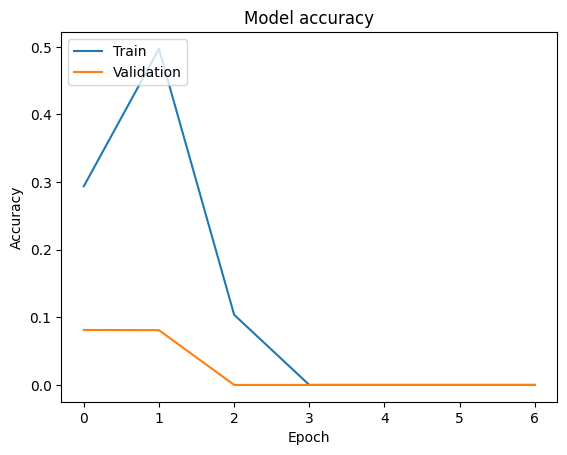

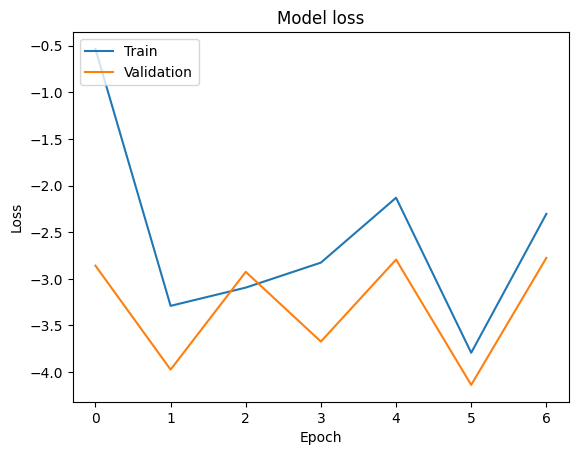

In [6]:
history = model.fit(
    X_train_resampled, y_train_resampled, epochs=20, validation_split=0.2, verbose=1, callbacks=[stop_early]
)
# history = model.fit(X_train, y_train, epochs=70, validation_split=0.2)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [6]:
history = model.fit(
    X_train_resampled, y_train_resampled, epochs=5, validation_split=0.2, verbose=1, callbacks=[stop_early]
)

# Evaluate the model on the test set
loss = model.evaluate(X_test, y_test, verbose=0)

print(f"Best Mixture Density Network loss: {loss}")

# Make predictions
y_pred = model.predict(X_test)



# Convert predictions to categorical outputs for evaluation
gm = tfp.distributions.MixtureSameFamily(
    mixture_distribution=tfp.distributions.Categorical(
        logits=y_pred[:, :num_components]
    ),
    components_distribution=tfp.distributions.Normal(
        loc=y_pred[:, num_components : num_components * 2],
        scale=tf.nn.softplus(y_pred[:, num_components * 2 :]),
    ),
)
y_pred_proba = gm.mean().numpy()  # Convert Tensor to NumPy array

# Ensure exactly half wins and half losses
num_samples = len(y_pred_proba)
num_wins = num_samples // 2
num_losses = num_samples - num_wins

# Get indices for the top probabilities for wins
indices_sorted = np.argsort(y_pred_proba.flatten())
indices_wins = indices_sorted[-num_wins:]
indices_losses = indices_sorted[:-num_wins]

# Create the final predictions
y_pred_final = np.zeros(num_samples)
y_pred_final[indices_wins] = 1  # Mark top probabilities as wins
# Remaining are losses

# Convert y_test from one-hot encoded format to single integer labels
y_test_single = np.argmax(y_test, axis=1)

# Evaluate the model
print("Best Mixture Density Network classification report:")
print(classification_report(y_test_single, y_pred_final))

# Confusion matrix
conf_matrix_mdn = confusion_matrix(y_test_single, y_pred_final)
sns.heatmap(conf_matrix_mdn, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

Epoch 1/20
1129/1129 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.0505 - loss: 0.9269 - val_accuracy: 0.0000e+00 - val_loss: -0.6560
Epoch 2/20
1129/1129 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.0000e+00 - loss: -1.5160 - val_accuracy: 0.0000e+00 - val_loss: -2.6547
Epoch 3/20
1129/1129 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.0000e+00 - loss: -3.0489 - val_accuracy: 0.0000e+00 - val_loss: 0.7919
Epoch 4/20
1129/1129 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.0000e+00 - loss: -3.6936 - val_accuracy: 0.0000e+00 - val_loss: -4.2688
Epoch 5/20
1129/1129 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.0000e+00 - loss: -4.0537 - val_accuracy: 0.0000e+00 - val_loss: -4.2076
Epoch 6/20
1129/1129 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.0000e+00 - loss: -4.1149 - val_accuracy: 0.0000e+00 - val_loss: -1.8051
Epoch 7/20
1129/1129 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.0000e+00 - loss: -3.2193 - val_accuracy: 0.0000e+00 - val_loss: -4.6407
Epoch 8/20
1129/1129 ━━━━━

2024-07-31 16:07:03.200958: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: INVALID_ARGUMENT: Incompatible shapes: [32] vs. [32,2]
	 [[{{node Equal}}]]


InvalidArgumentError: Graph execution error:

Detected at node Equal defined at (most recent call last):
  File "/usr/lib/python3.10/runpy.py", line 196, in _run_module_as_main

  File "/usr/lib/python3.10/runpy.py", line 86, in _run_code

  File "/home/rohanbendapudi/MLenv/lib/python3.10/site-packages/ipykernel_launcher.py", line 18, in <module>

  File "/home/rohanbendapudi/MLenv/lib/python3.10/site-packages/traitlets/config/application.py", line 1075, in launch_instance

  File "/home/rohanbendapudi/MLenv/lib/python3.10/site-packages/ipykernel/kernelapp.py", line 739, in start

  File "/home/rohanbendapudi/MLenv/lib/python3.10/site-packages/tornado/platform/asyncio.py", line 205, in start

  File "/usr/lib/python3.10/asyncio/base_events.py", line 603, in run_forever

  File "/usr/lib/python3.10/asyncio/base_events.py", line 1909, in _run_once

  File "/usr/lib/python3.10/asyncio/events.py", line 80, in _run

  File "/home/rohanbendapudi/MLenv/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 545, in dispatch_queue

  File "/home/rohanbendapudi/MLenv/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 534, in process_one

  File "/home/rohanbendapudi/MLenv/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 437, in dispatch_shell

  File "/home/rohanbendapudi/MLenv/lib/python3.10/site-packages/ipykernel/ipkernel.py", line 362, in execute_request

  File "/home/rohanbendapudi/MLenv/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 778, in execute_request

  File "/home/rohanbendapudi/MLenv/lib/python3.10/site-packages/ipykernel/ipkernel.py", line 449, in do_execute

  File "/home/rohanbendapudi/MLenv/lib/python3.10/site-packages/ipykernel/zmqshell.py", line 549, in run_cell

  File "/home/rohanbendapudi/MLenv/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3075, in run_cell

  File "/home/rohanbendapudi/MLenv/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3130, in _run_cell

  File "/home/rohanbendapudi/MLenv/lib/python3.10/site-packages/IPython/core/async_helpers.py", line 128, in _pseudo_sync_runner

  File "/home/rohanbendapudi/MLenv/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3334, in run_cell_async

  File "/home/rohanbendapudi/MLenv/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3517, in run_ast_nodes

  File "/home/rohanbendapudi/MLenv/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3577, in run_code

  File "/tmp/ipykernel_409449/811798200.py", line 6, in <module>

  File "/home/rohanbendapudi/MLenv/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/home/rohanbendapudi/MLenv/lib/python3.10/site-packages/keras/src/backend/tensorflow/trainer.py", line 429, in evaluate

  File "/home/rohanbendapudi/MLenv/lib/python3.10/site-packages/keras/src/backend/tensorflow/trainer.py", line 165, in one_step_on_iterator

  File "/home/rohanbendapudi/MLenv/lib/python3.10/site-packages/keras/src/backend/tensorflow/trainer.py", line 154, in one_step_on_data

  File "/home/rohanbendapudi/MLenv/lib/python3.10/site-packages/keras/src/backend/tensorflow/trainer.py", line 91, in test_step

  File "/home/rohanbendapudi/MLenv/lib/python3.10/site-packages/keras/src/trainers/trainer.py", line 444, in compute_metrics

  File "/home/rohanbendapudi/MLenv/lib/python3.10/site-packages/keras/src/trainers/compile_utils.py", line 330, in update_state

  File "/home/rohanbendapudi/MLenv/lib/python3.10/site-packages/keras/src/trainers/compile_utils.py", line 17, in update_state

  File "/home/rohanbendapudi/MLenv/lib/python3.10/site-packages/keras/src/metrics/reduction_metrics.py", line 204, in update_state

  File "/home/rohanbendapudi/MLenv/lib/python3.10/site-packages/keras/src/metrics/accuracy_metrics.py", line 246, in sparse_categorical_accuracy

  File "/home/rohanbendapudi/MLenv/lib/python3.10/site-packages/keras/src/ops/numpy.py", line 2355, in equal

  File "/home/rohanbendapudi/MLenv/lib/python3.10/site-packages/keras/src/backend/tensorflow/numpy.py", line 1144, in equal

Incompatible shapes: [32] vs. [32,2]
	 [[{{node Equal}}]] [Op:__inference_one_step_on_iterator_510194]